In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
import matplotlib.pyplot as plt

import numpy as np

# Create a Spark session
spark = SparkSession.builder.appName("MySparkApp").getOrCreate()
sc = SparkContext.getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/17 18:58:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Read File
parallelReadFile: It receives a String filename with name of the csv file of the dataset. The function returns a
Spark RDD with the loaded data.

In [2]:
def parallelReadFile(filename):
    # Read the file into an RDD
    rdd = sc.textFile(filename)

    # Assuming the first line of the CSV is the header
    header = rdd.first()

    # Use flatMap to filter out the header
    dataWithoutHeader = rdd.flatMap(lambda line: [] if line == header else [line])

    # Process the RDD to remove the first column and convert elements to float
    rdd_processed = dataWithoutHeader.map(lambda line: [float(item) for item in line.split(',')[1:]])

    return rdd_processed


## Assign to cluster
parallelAssign2cluster: It receives a list of d-dimensional tuples called centroids, representing the current
state of the centroids, and a d-dimensional tuple x which represents the datum to be assigned to a cluster. It returns
an integer with the index in centroids of the closest centroid to x.

In [3]:
def parallelAssign2cluster(centroids, x):
    distances = [np.sqrt(np.sum(np.square(x - centroid))) for centroid in centroids]
    closest_index = np.argmin(distances)
    return (closest_index, np.array(x))

## Parallel K Means
parallelKMeans: Performs the parallelized K-Means algorithm on the RDD dataset data, grouping the
instances into K different clusters. The number of iterations of the method to be executed is n_iter. The
initialization of the centroids will be random, sampled from a standard normal distribution. It returns a list of
length K with the d-dimensional centroids computed.

In [4]:

def parallelKMeans(data, K, n_iter):    
    centroids = [np.random.rand(len(data.first())) for _ in range(K)]

    for n in range(n_iter):
        # Assign points to the nearest centroid
        cluster_assignments = data.map(lambda x: parallelAssign2cluster(centroids, x))

        # Perform sum and count in a single reduceByKey operation
        centroid_sum_count = cluster_assignments.map(lambda x: (x[0], (x[1], 1))).reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

        
        mean_centroids_list = centroid_sum_count.map(lambda x: (x[1][0] / x[1][1])).collect()

        centroids = mean_centroids_list
        print("Iteration {}".format(n+1))
    return centroids



## Main
Here we can change the number of workers and we save the execution time.

Number of cores:  1


Iteration 1:


Iteration 2:


Iteration 3:


Iteration 4:


Iteration 5:


Iteration 6:


Iteration 7:


Iteration 8:


Iteration 9:


Iteration 10:
Number of cores:  2


Iteration 1:


Iteration 2:


Iteration 3:


Iteration 4:


Iteration 5:


Iteration 6:


Iteration 7:


Iteration 8:


Iteration 9:


Iteration 10:
Number of cores:  3


Iteration 1:


Iteration 2:


Iteration 3:


Iteration 4:


Iteration 5:


Iteration 6:


Iteration 7:


Iteration 8:


Iteration 9:


Iteration 10:
Number of cores:  4


Iteration 1:


Iteration 2:


Iteration 3:


Iteration 4:


Iteration 5:


Iteration 6:


Iteration 7:


Iteration 8:


Iteration 9:


Iteration 10:
Number of cores:  5


Iteration 1:


Iteration 2:


Iteration 3:


Iteration 4:


Iteration 5:


Iteration 6:


Iteration 7:


Iteration 8:


Iteration 9:


Iteration 10:
Number of cores:  6


Iteration 1:


Iteration 2:


Iteration 3:


Iteration 4:


Iteration 5:


Iteration 6:


Iteration 7:


Iteration 8:


Iteration 9:


Iteration 10:
Number of cores:  7


Iteration 1:


Iteration 2:


Iteration 3:


Iteration 4:


Iteration 5:


Iteration 6:


Iteration 7:


Iteration 8:


Iteration 9:


Iteration 10:
Number of cores:  8


Iteration 1:


Iteration 2:


Iteration 3:


Iteration 4:


Iteration 5:


Iteration 6:


Iteration 7:


Iteration 8:


Iteration 9:


Iteration 10:
Number of cores:  9


Iteration 1:


Iteration 2:


Iteration 3:


Iteration 4:


Iteration 5:


Iteration 6:


Iteration 7:


Iteration 8:


Iteration 9:


Iteration 10:
Number of cores:  10


Iteration 1:


Iteration 2:


Iteration 3:


Iteration 4:


Iteration 5:


Iteration 6:


Iteration 7:


Iteration 8:


Iteration 9:


Iteration 10:
Number of cores:  11


Iteration 1:


Iteration 2:


Iteration 3:


Iteration 4:


Iteration 5:


Iteration 6:


Iteration 7:


Iteration 8:


Iteration 9:


Iteration 10:
Number of cores:  12


Iteration 1:


Iteration 2:


Iteration 3:


Iteration 4:


Iteration 5:


Iteration 6:


Iteration 7:


Iteration 8:


Iteration 9:


Iteration 10:


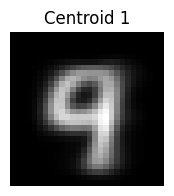

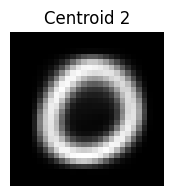

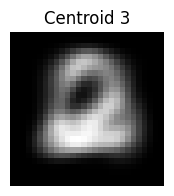

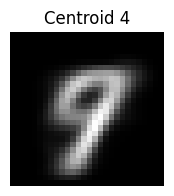

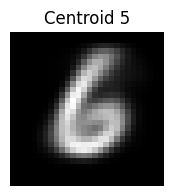

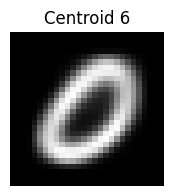

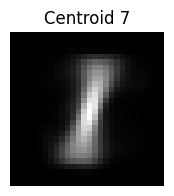

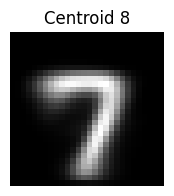

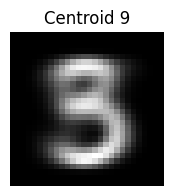

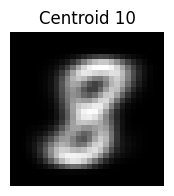

In [5]:
import os
import sys
import time

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
import pyspark
sc.stop()
times = []
for i in range(1, 13):
    print("Number of cores: ", i)
    start_time = time.time()
    number_cores = i
    conf = (
        pyspark.SparkConf()
            .setMaster('local[{}]'.format(number_cores))
    )
    sc = pyspark.SparkContext(conf=conf)

    filename = 'data/tot_mnist_shuf.csv'
    RDD_Xy = parallelReadFile(filename)
    centroids = parallelKMeans(RDD_Xy, 10, 10)
    times.append(time.time() - start_time)
    sc.stop()
for j, centroid in enumerate(centroids):
        image = centroid.reshape((28, 28))  
        fig = plt.figure(figsize=(2, 2))  
        plt.imshow(image, cmap='grey')  
        plt.title(f'Centroid {j+1}')
        plt.axis('off') 
        plt.show()

Number of clusters: 3


Iteration 1:


Iteration 2:


Iteration 3:


Iteration 4:


Iteration 5:


Iteration 6:


Iteration 7:


Iteration 8:


Iteration 9:


Iteration 10:


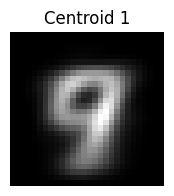

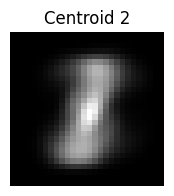

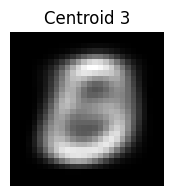

Number of clusters: 5


Iteration 1:


Iteration 2:


Iteration 3:


Iteration 4:


Iteration 5:


Iteration 6:


Iteration 7:


Iteration 8:


Iteration 9:


Iteration 10:


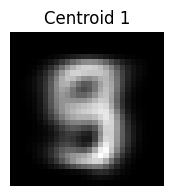

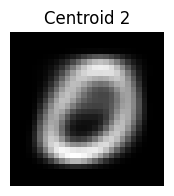

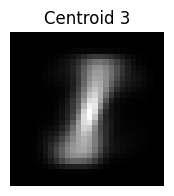

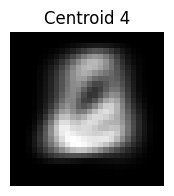

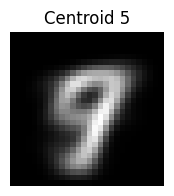

Number of clusters: 7


Iteration 1:


Iteration 2:


Iteration 3:


Iteration 4:


Iteration 5:


Iteration 6:


Iteration 7:


Iteration 8:


Iteration 9:


Iteration 10:


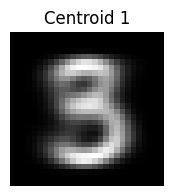

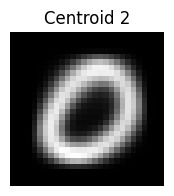

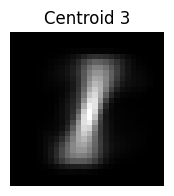

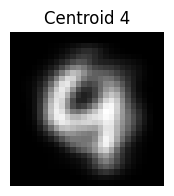

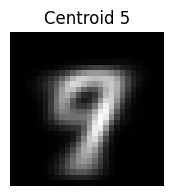

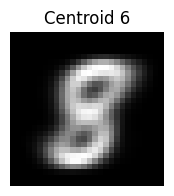

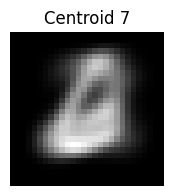

Number of clusters: 8


Iteration 1:


Iteration 2:


Iteration 3:


Iteration 4:


Iteration 5:


Iteration 6:


Iteration 7:


Iteration 8:


Iteration 9:


Iteration 10:


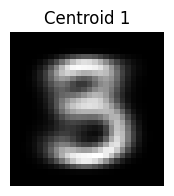

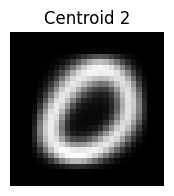

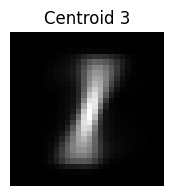

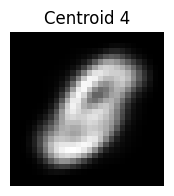

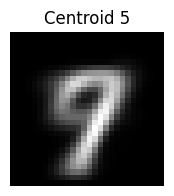

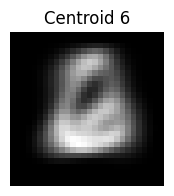

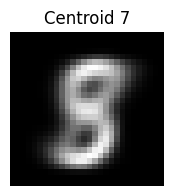

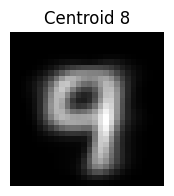

Number of clusters: 9


Iteration 1:


Iteration 2:


Iteration 3:


Iteration 4:


Iteration 5:


Iteration 6:


Iteration 7:


Iteration 8:


Iteration 9:


Iteration 10:


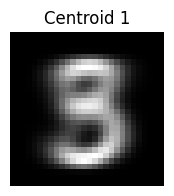

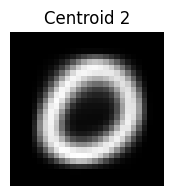

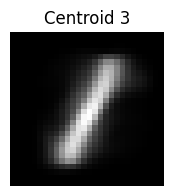

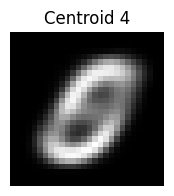

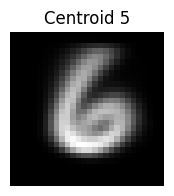

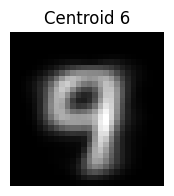

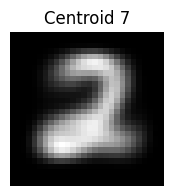

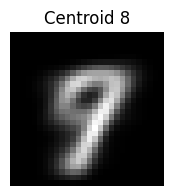

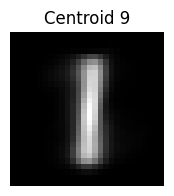

Number of clusters: 10


Iteration 1:


Iteration 2:


Iteration 3:


Iteration 4:


Iteration 5:


Iteration 6:


Iteration 7:


Iteration 8:


Iteration 9:


Iteration 10:


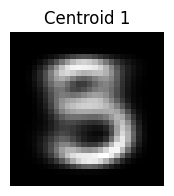

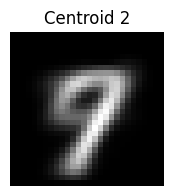

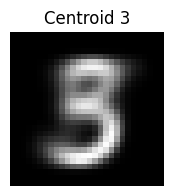

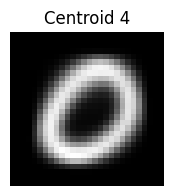

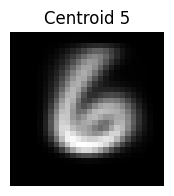

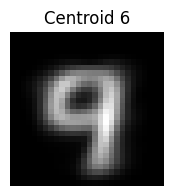

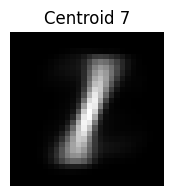

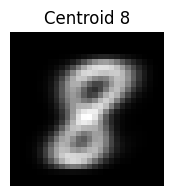

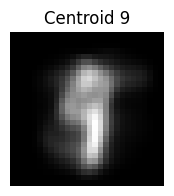

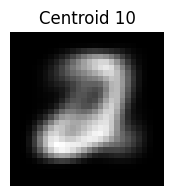

Number of clusters: 11


Iteration 1:


Iteration 2:


Iteration 3:


Iteration 4:


Iteration 5:


Iteration 6:


Iteration 7:


Iteration 8:


Iteration 9:


Iteration 10:


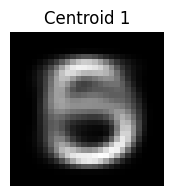

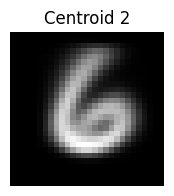

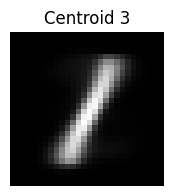

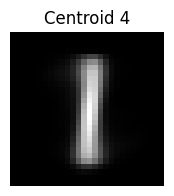

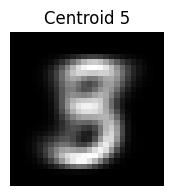

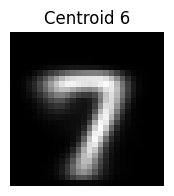

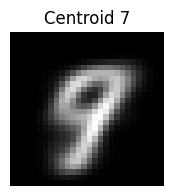

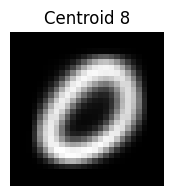

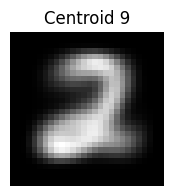

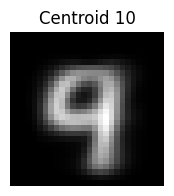

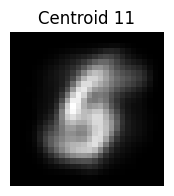

In [6]:

k_values = [3, 5, 7, 8, 9, 10, 11] 
times_K = []  # List to store execution times for different K values


conf = pyspark.SparkConf().setMaster(f'local[{10}]')
sc = pyspark.SparkContext(conf=conf)
filename = 'data/tot_mnist_shuf.csv'
RDD_Xy = parallelReadFile(filename)
for k in k_values: 
    print("Number of clusters:", k)     
    start_time_k = time.time()
    centroids = parallelKMeans(RDD_Xy, k, 10)
    times_K.append(start_time_k - time.time())
    for j, centroid in enumerate(centroids):
        image = centroid.reshape((28, 28))  
        fig = plt.figure(figsize=(2, 2))  
        plt.imshow(image, cmap='grey')  
        plt.title(f'Centroid {j+1}')
        plt.axis('off') 
        plt.show()
sc.stop()



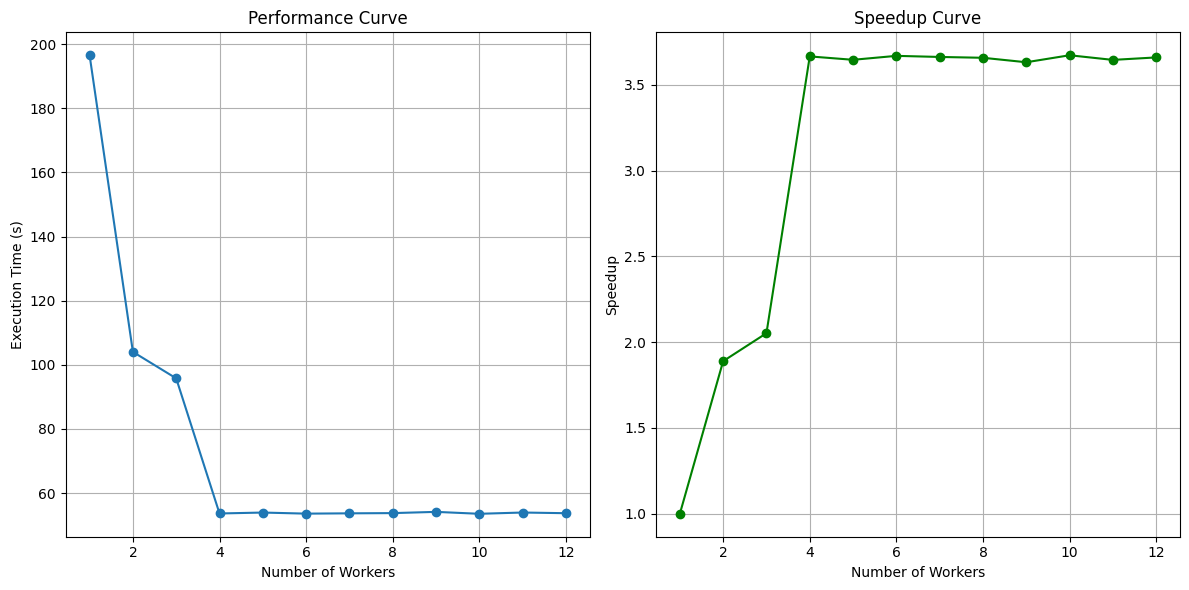

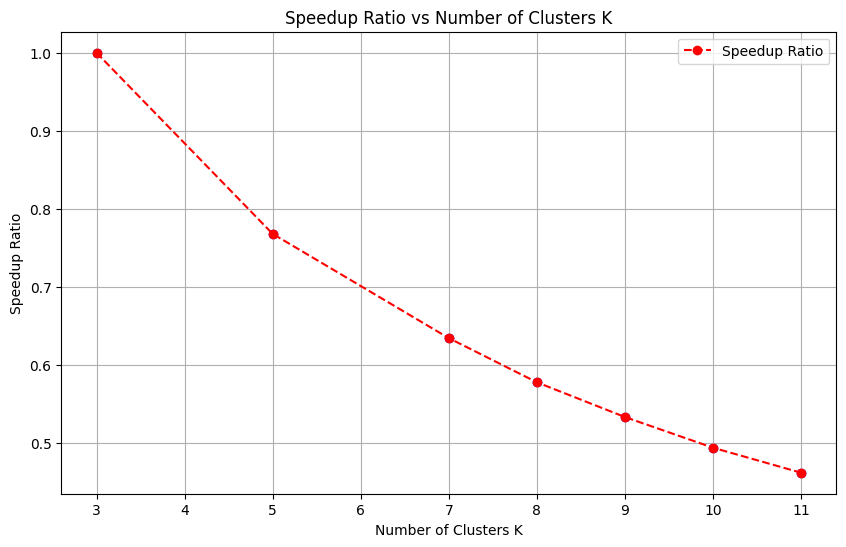

In [8]:
import matplotlib.pyplot as plt

number_of_workers = list(range(1, 13)) 

# Calculating speedup
base_time = times[0]  # Time taken for execution with 1 worker
speedup = [base_time / t for t in times]
speedup_K = [times_K[0] / t for t in times_K]

# Plotting performance curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(number_of_workers, times, marker='o')
plt.title('Performance Curve')
plt.xlabel('Number of Workers')
plt.ylabel('Execution Time (s)')
plt.grid(True)

# Plotting speedup curve
plt.subplot(1, 2, 2)
plt.plot(number_of_workers, speedup, marker='o', color='green')
plt.title('Speedup Curve')
plt.xlabel('Number of Workers')
plt.ylabel('Speedup')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

# Plotting speedup ratio for each K value
plt.figure(figsize=(10, 6))
plt.scatter(k_values, speedup_K, color='b')  # Using scatter since we have discrete points

# Optionally, you can plot a line connecting the points
plt.plot(k_values, speedup_K, color='r', linestyle='dashed', marker='o', label='Speedup Ratio')

plt.title('Speedup Ratio vs Number of Clusters K')
plt.xlabel('Number of Clusters K')
plt.ylabel('Speedup Ratio')
plt.legend()
plt.grid(True)
plt.show()